# Prevalence of people with insufficient food consumption released by World Food Programme (WFP)

In this notebook, we process the data obtained from **Food Consumption Score (FCS)** indicator in order to obtain the time series related to the prevalence of people with insufficient food consumption. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from MapPlot.MapPlot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Load the data released by wfp regarding the prevalence of people with insufficient food consumption stored in the 'WFP_data' folder.
COUNTRIES = ["Syria", "Yemen", "Burkina Faso", "Nigeria", "Mali", "Cameroon"]

path = "./WFP_data/"
dfs = []

for country in COUNTRIES:
    df = pd.read_csv(f"{path}/{country}.csv")
    df["Country"] = country
    dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2018-8-1_2018-8-31,2018-08-31,Rural Damascus,900230,24.9358,3177441,792320,Syria
1,2018-8-1_2018-8-31,2018-08-31,Dar'a,900223,36.1552,565619,204500,Syria
2,2018-8-1_2018-8-31,2018-08-31,Al-Hasakeh,900218,35.8548,1010783,362414,Syria
3,2018-8-1_2018-8-31,2018-08-31,Tartous,900231,20.3846,813169,165761,Syria
4,2018-8-1_2018-8-31,2018-08-31,Hama,900225,18.1115,1538162,278584,Syria


### Brief items description

- *SvyDate*: reference period of the data collection;
- *Date*: reference date (i.e. the end of the reference period);
- *Dmgrph*: administrative area name;
- *DmgrphCode*: a code for identyfing the adminstrata;
- *Mean_crrnt*: % of people with poor and borderline food consumption during the corresponding SvyDate;
- *Pop*: area population size;
- *PopNmbr*: number of people with poor and borderline food consumption (i.e. Mean_crrnt * Pop);
- *Country*: country name;

N.B. In the following, we will indicate the prevalence of people with poor and borderline food consumption (FCG <= 2) with the 'FCG' notation only (1 = poor, 2 = borderline, 3 = acceptable). 

In [6]:
# Check if the dataframe contains some NaN values.
df.isnull().sum()

SvyDate       0
Date          0
Dmgrph        0
DmgrphCode    0
Mean_crrnt    0
Pop           0
PopNmbr       0
Country       0
dtype: int64

In [7]:
# Let's delete some item columns because they are not of interest in this notebook.
df.drop(["Pop", "PopNmbr"], axis = 1, inplace = True) 

In [8]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "FCG"}, inplace = True)

In [9]:
# Check the temporal ranges of the SvyDate column creating two new columns.
df[["SvyDate1", "SvyDate2"]] = df["SvyDate"].apply(lambda x: x.split("_")).apply(pd.Series).apply(pd.to_datetime)
# The new column 'SvyDateRange' indicates the coverage of days of the survey [SvyDate1, SvyDate2].
df["SvyDateRange"] = (df["SvyDate2"] - df["SvyDate1"]).dt.days + 1
df.head()

,SvyDate,Datetime,AdminStrata,DmgrphCode,FCG,Country,SvyDate1,SvyDate2,SvyDateRange
0,2018-8-1_2018-8-31,2018-08-31,Rural Damascus,900230,24.9358,Syria,2018-08-01,2018-08-31,31
1,2018-8-1_2018-8-31,2018-08-31,Dar'a,900223,36.1552,Syria,2018-08-01,2018-08-31,31
2,2018-8-1_2018-8-31,2018-08-31,Al-Hasakeh,900218,35.8548,Syria,2018-08-01,2018-08-31,31
3,2018-8-1_2018-8-31,2018-08-31,Tartous,900231,20.3846,Syria,2018-08-01,2018-08-31,31
4,2018-8-1_2018-8-31,2018-08-31,Hama,900225,18.1115,Syria,2018-08-01,2018-08-31,31


In [10]:
# Check what are the temporal coverages of countries.
df.groupby("Country")["SvyDateRange"].unique()

Country
Burkina Faso        [56, 30]
Cameroon            [30, 90]
Mali            [28, 84, 30]
Nigeria             [31, 30]
Syria                   [31]
Yemen                   [31]
Name: SvyDateRange, dtype: object

In [11]:
df.set_index(["Country", "AdminStrata", "Datetime"]).index.is_unique

True

### Country item

In [12]:
print("The countries are:", ", ".join(df["Country"].unique()))

The countries are: Syria, Yemen, Burkina Faso, Nigeria, Mali, Cameroon


### AdminStrata item

In [13]:
# We change the string of some adminstratas to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country in ["Burkina Faso", "Cameroon", "Mali", "Niger"]:
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [14]:
# Rename some regions.
df.replace(["Tombouctou/Taoudeni", "Gao/Menaka"], ["Tombouctou-Taoudeni", "Gao-Menaka"], inplace = True)

In [15]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the administrative regions of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago. The FCG dataframe has the values of all the 22 administrative regions.

N.B. Hadramaut and Socotra have identical time series related to FCG.

In [16]:
# Map from code to adminstrata name.
#df[df["Country"] == "Yemen"][["DmgrphCode", "AdminStrata"]].drop_duplicates().set_index("DmgrphCode")["AdminStrata"].to_dict()

In [17]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Socotra', 'Abyan', 'Al Hudaydah', 'Al Jawf', 'Al Maharah',
       'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar', 'Hadramaut',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', "Sa'ada", "Sana'a",
       'Shabwah', 'Taizz', 'Aden', 'Al Bayda', "Al Dhale'e"], dtype=object)

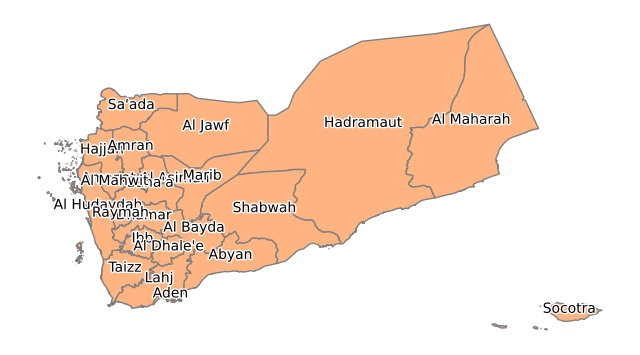

In [18]:
# Plot map.
draw_adminstratas(country = "Yemen", adminstratas_to_highlight = AdminStratas["Yemen"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Yemen/map_fcs.png", dpi = 300)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The FCG dataframe has the values of all 13 administrative regions.

In [19]:
# Map from code to adminstrata name.
#df[df["Country"] == "Burkina Faso"][["DmgrphCode", "AdminStrata"]].drop_duplicates().set_index("DmgrphCode")["AdminStrata"].to_dict()

In [20]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

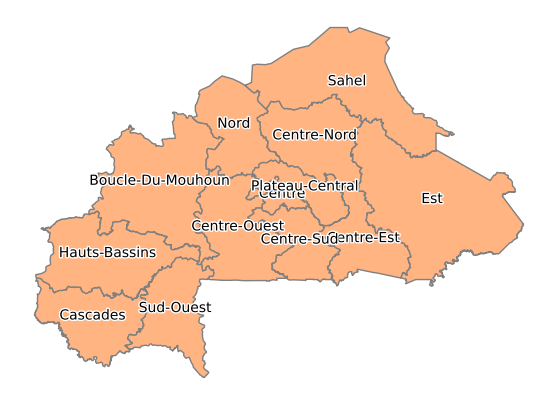

In [21]:
# Plot map.
draw_adminstratas(country = "Burkina Faso", adminstratas_to_highlight = AdminStratas["Burkina Faso"],  figsize = (8, 5), 
                  annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Burkina Faso/map_fcs.png", dpi = 300)

- **Syria (SYR)**: the administrative regions of Syria country are 14. The FCG dataframe has the values of 13 administrative regions (Idleb administrative region not included).

In [22]:
# Map from code to adminstrata name.
#df[df["Country"] == "Syria"][["DmgrphCode", "AdminStrata"]].drop_duplicates().set_index("DmgrphCode")["AdminStrata"].to_dict()

In [23]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Rural Damascus', "Dar'a", 'Al-Hasakeh', 'Tartous', 'Hama',
       'Aleppo', 'Homs', 'As-Sweida', 'Lattakia', 'Damascus',
       'Deir-ez-Zor', 'Ar-Raqqa', 'Quneitra'], dtype=object)

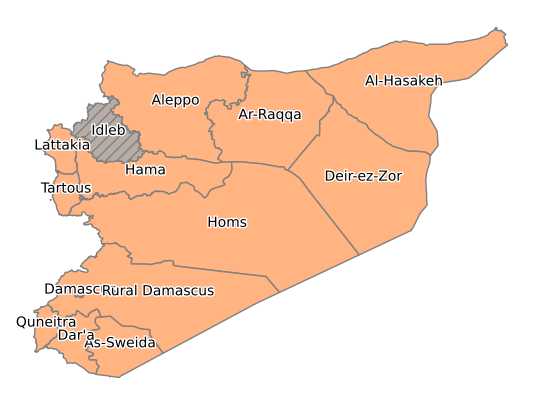

In [24]:
# Plot map.
draw_adminstratas(country = "Syria", adminstratas_to_highlight = AdminStratas["Syria"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Syria/map_fcs.png", dpi = 300)

- **Cameroon (CMR)**: the administrative regions of Cameroon are 10. The FCG dataframe has the values of all the 10 administrative regions.

In [25]:
# Map from code to adminstrata name.
#df[df["Country"] == "Cameroon"][["DmgrphCode", "AdminStrata"]].drop_duplicates().set_index("DmgrphCode")["AdminStrata"].to_dict()

In [26]:
print(AdminStratas["Cameroon"].shape)
AdminStratas["Cameroon"]

(10,)


array(['North-West', 'South-West', 'Adamawa', 'Central', 'East',
       'Far-North', 'Littoral', 'North', 'South', 'West'], dtype=object)

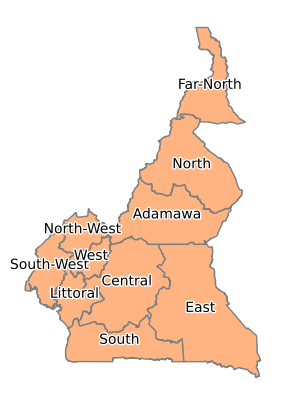

In [27]:
# Plot map.
draw_adminstratas(country = "Cameroon", adminstratas_to_highlight = AdminStratas["Cameroon"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Cameroon/map_fcs.png", dpi = 300)

- **Mali (MLI)**: Mali is divided into eight regions and one capital district (Bamako). The AdminStrata items of the FCG dataframe cover all 9 regions.

In [28]:
# Map from code to adminstrata name.
#df[df["Country"] == "Mali"][["DmgrphCode", "AdminStrata"]].drop_duplicates().set_index("DmgrphCode")["AdminStrata"].to_dict()

In [29]:
print(AdminStratas["Mali"].shape)
AdminStratas["Mali"]

(9,)


array(['Mopti', 'Segou', 'Tombouctou-Taoudeni', 'Bamako', 'Kayes',
       'Koulikoro', 'Sikasso', 'Gao-Menaka', 'Kidal'], dtype=object)

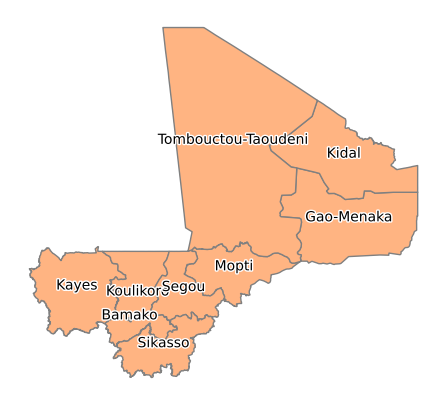

In [30]:
# Plot map.
draw_adminstratas(country = "Mali", adminstratas_to_highlight = AdminStratas["Mali"], figsize = (8, 5), annotation = True, 
                  path_to_save = PATH_TO_SAVE_DATA + "Mali/map_fcs.png", dpi = 300)

- **Nigeria (NGA)**: Nigeria is divided into 36 administrative regions. It also includes The Federal Capital Territory that is is under the direct control of the federal government. The AdminStrata items of the FCG dataframe cover 3 administrative regions: Adamawa, Borno and Yobe.

In [31]:
# Map from code to adminstrata name.
#df[df["Country"] == "Nigeria"][["DmgrphCode", "AdminStrata"]].drop_duplicates().set_index("DmgrphCode")["AdminStrata"].to_dict()

In [32]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(3,)


array(['Adamawa', 'Borno', 'Yobe'], dtype=object)

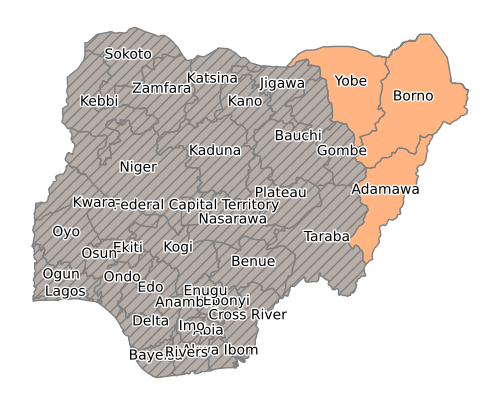

In [33]:
# Plot map.
draw_adminstratas(country = "Nigeria", adminstratas_to_highlight = AdminStratas["Nigeria"], figsize = (8, 5), annotation = True,
                  annotation_selected = True, path_to_save = PATH_TO_SAVE_DATA + "Nigeria/map_fcs.png", dpi = 300)

## Data analysis

In [34]:
# Check the min e max values of the FCG column (% of people with poor and borderline food consumption).
print("min: %f, max: %f" % (df["FCG"].min(), df["FCG"].max()))

min: 0.000000, max: 93.358950


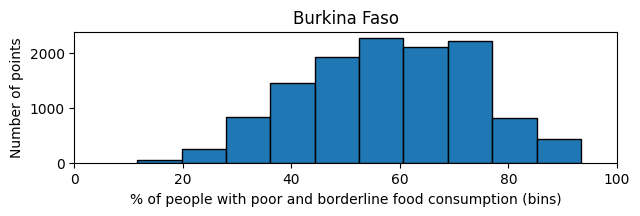

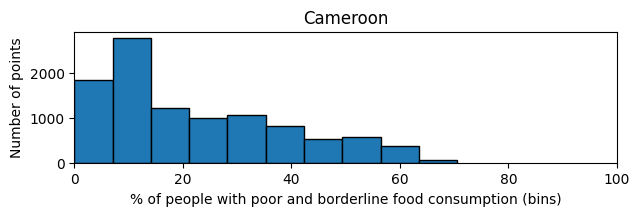

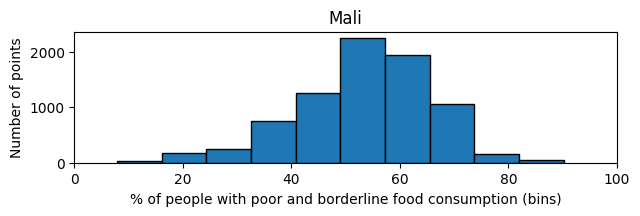

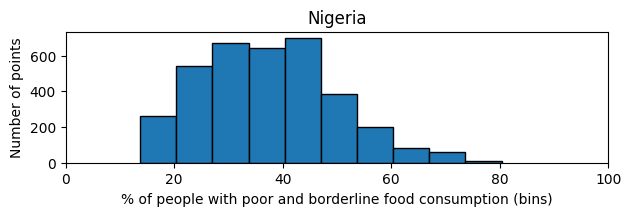

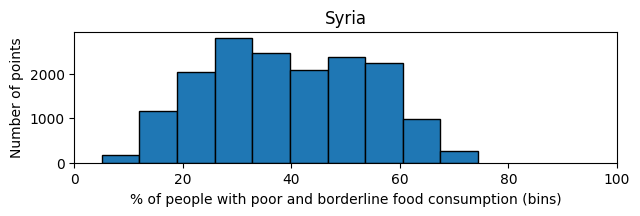

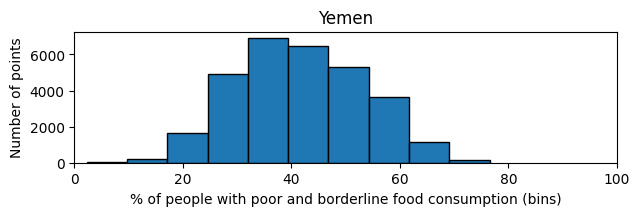

In [35]:
# Create an histogram referred to the values of the FCG for each country.
def hist_fcs(group):
    # Plot hist.
    fig, ax = plt.subplots(figsize = (7, 1.7))
    data = group["FCG"].dropna().values
    ax.hist(data, ec = "k")
    ax.set_title(group.name)
    ax.set_ylabel("Number of points")
    ax.set_xlabel("% of people with poor and borderline food consumption (bins)")
    ax.set_xlim([0, 100])
    plt.show()

df.groupby("Country").apply(hist_fcs);

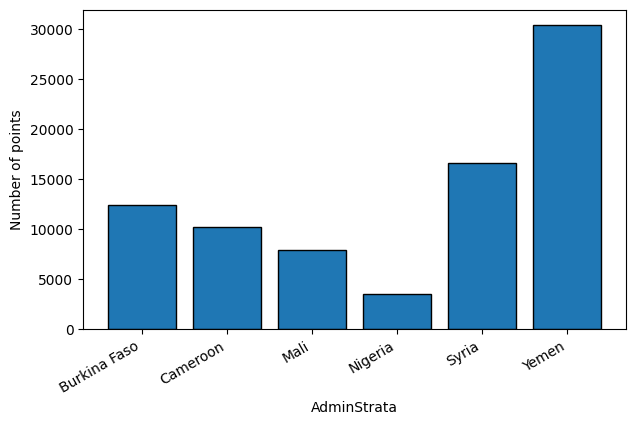

In [36]:
# Create an histogram referred to the number of total points for each country.
n_points = df.groupby("Country")["FCG"].count()

fig, ax = plt.subplots(figsize = (7, 4.7))
ax.bar(n_points.index, n_points.values, ec = "k")
ax.set_ylabel("Number of points")
ax.set_xlabel("AdminStrata")
fig.autofmt_xdate()
plt.show()

## Creation of the time series

We create the time series based on the FCG and SvyDateRange values.

In [37]:
# Delete the unused columns.
df.drop(["SvyDate", "SvyDate1", "SvyDate2"], axis = 1, inplace = True) 
# Creation of an accurate datetime format.
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
# Create time series.
df = df.groupby(["Country", "AdminStrata"]).apply(lambda x: x.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,DmgrphCode,FCG,SvyDateRange
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,900712.0,30.92170,56.0
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,900712.0,31.10393,56.0
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,900712.0,32.03030,56.0
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,900712.0,32.16730,56.0
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,900712.0,31.77005,56.0


In [38]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time series.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"]).reorder_levels([1, 2, 0], axis = 1).sort_index(axis = 1, level = [0, 1, 2])
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                               \
AdminStrata Boucle-Du-Mouhoun                    Cascades                    
Indicator          DmgrphCode FCG SvyDateRange DmgrphCode FCG SvyDateRange   
Datetime                                                                     
2018-07-02                NaN NaN          NaN        NaN NaN          NaN   
2018-07-03                NaN NaN          NaN        NaN NaN          NaN   
2018-07-04                NaN NaN          NaN        NaN NaN          NaN   
2018-07-05                NaN NaN          NaN        NaN NaN          NaN   
2018-07-06                NaN NaN          NaN        NaN NaN          NaN   

Country                                             ...        Yemen  \
AdminStrata     Centre                  Centre-Est  ...       Sana'a   
Indicator   DmgrphCode FCG SvyDateRange DmgrphCode  ... SvyDateRange   
Datetime                                            ...                
2018-07-02         NaN NaN          NaN        NaN  ...         31.0   
2018-07-03         NaN NaN          NaN        NaN  ...         31.0   
2018-07-04         NaN NaN          NaN        NaN  ...         31.0   
2018-07-05         NaN NaN          NaN        NaN  ...         31.0   
2018-07-06         NaN NaN          NaN        NaN  ...         31.0   

Country                                                               \
AdminStrata    Shabwah                            Socotra              
Indicator   DmgrphCode        FCG SvyDateRange DmgrphCode        FCG   
Datetime                                                               
2018-07-02      3424.0  16.752289         31.0   900101.0  23.822825   
2018-07-03      3424.0  18.257453         31.0   900101.0  23.699881   
2018-07-04      3424.0  19.083081         31.0   900101.0  23.103187   
2018-07-05      3424.0  20.349533         31.0   900101.0  21.596419   
2018-07-06      3424.0  21.107524         31.0   900101.0  20.129084   

Country                                                      
AdminStrata                   Taizz                          
Indicator   SvyDateRange DmgrphCode        FCG SvyDateRange  
Datetime                                                     
2018-07-02          31.0     3425.0  26.563365         31.0  
2018-07-03          31.0     3425.0  29.124005         31.0  
2018-07-04          31.0     3425.0  29.427973         31.0  
2018-07-05          31.0     3425.0  30.456026         31.0  
2018-07-06          31.0     3425.0  31.012517         31.0  

[5 rows x 210 columns]

In [39]:
# Plot the time series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline food consumption", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()

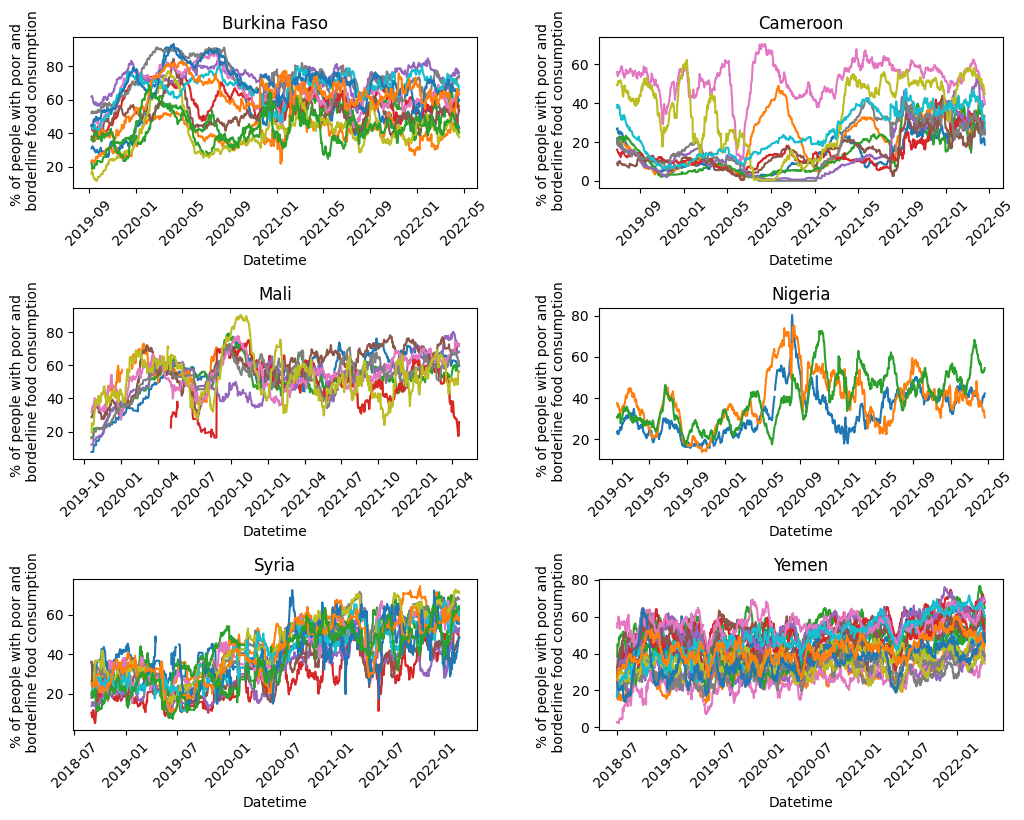

In [40]:
# Plot the original time series of the FCG for each country.
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 9))
fig.subplots_adjust(hspace = .8, wspace = .3)
axs = axs.ravel()
for i, country in enumerate(df.columns.get_level_values("Country").unique()):
    axs[i].plot(df[country].xs("FCG", axis = 1, level = "Indicator", drop_level = False))
    axs[i].set_title(country)
    axs[i].set_xlabel("Datetime")
    axs[i].set_ylabel("% of people with poor and \n borderline food consumption")
    axs[i].tick_params(axis = "x", labelrotation = 45)
# Remove extra plot.
#axs[-1].set_axis_off()
# Save the figure.
fig.savefig(PATH_TO_SAVE_DATA + "time_series.png", dpi = 300, bbox_inches = "tight")

In [41]:
# Now save the time series at country level keeping as indeces for each group of time series the own first and last valid indeces.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [42]:
# Save the dataframe.
df.xs("FCG", axis = 1, level = "Indicator", drop_level = False).groupby(level = "Country", axis = 1).apply(lambda x: save(x, name = "wfp_fcs"));

## Adjustment of the time series: interpolation of NaN values

In [43]:
def check_nan(x): 
    return x.loc[x.first_valid_index():x.last_valid_index()].xs("FCG", axis = 1, level = "Indicator").isna().sum().sum()

# Check number of nan values at administrative level.
nans = df.groupby(axis = 1, level = ["Country", "AdminStrata"]).apply(check_nan)
nans.sort_values(ascending = False).head(10)

Country  AdminStrata     
Syria    Quneitra            178
Mali     Gao-Menaka           56
         Kidal                34
Yemen    Taizz                 4
         Amanat Al Asimah      4
         Abyan                 4
         Aden                  4
         Al Bayda              4
         Al Dhale'e            4
         Al Hudaydah           4
dtype: int64

In [44]:
def interpolation(x): 
    # Let's interpolate the NaN values using a linear interpolation up to a limit of 7 days.
    x = x.loc[x.first_valid_index():x.last_valid_index()]
    x = x.interpolate(method = "linear", limit = 7)
    return x

df_interpolate = df.groupby(axis = 1, level = ["Country", "AdminStrata"], group_keys = False).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                               \
AdminStrata Boucle-Du-Mouhoun                    Cascades                    
Indicator          DmgrphCode FCG SvyDateRange DmgrphCode FCG SvyDateRange   
Datetime                                                                     
2018-07-02                NaN NaN          NaN        NaN NaN          NaN   
2018-07-03                NaN NaN          NaN        NaN NaN          NaN   
2018-07-04                NaN NaN          NaN        NaN NaN          NaN   
2018-07-05                NaN NaN          NaN        NaN NaN          NaN   
2018-07-06                NaN NaN          NaN        NaN NaN          NaN   

Country                                             ...        Yemen  \
AdminStrata     Centre                  Centre-Est  ...       Sana'a   
Indicator   DmgrphCode FCG SvyDateRange DmgrphCode  ... SvyDateRange   
Datetime                                            ...                
2018-07-02         NaN NaN          NaN        NaN  ...         31.0   
2018-07-03         NaN NaN          NaN        NaN  ...         31.0   
2018-07-04         NaN NaN          NaN        NaN  ...         31.0   
2018-07-05         NaN NaN          NaN        NaN  ...         31.0   
2018-07-06         NaN NaN          NaN        NaN  ...         31.0   

Country                                                               \
AdminStrata    Shabwah                            Socotra              
Indicator   DmgrphCode        FCG SvyDateRange DmgrphCode        FCG   
Datetime                                                               
2018-07-02      3424.0  16.752289         31.0   900101.0  23.822825   
2018-07-03      3424.0  18.257453         31.0   900101.0  23.699881   
2018-07-04      3424.0  19.083081         31.0   900101.0  23.103187   
2018-07-05      3424.0  20.349533         31.0   900101.0  21.596419   
2018-07-06      3424.0  21.107524         31.0   900101.0  20.129084   

Country                                                      
AdminStrata                   Taizz                          
Indicator   SvyDateRange DmgrphCode        FCG SvyDateRange  
Datetime                                                     
2018-07-02          31.0     3425.0  26.563365         31.0  
2018-07-03          31.0     3425.0  29.124005         31.0  
2018-07-04          31.0     3425.0  29.427973         31.0  
2018-07-05          31.0     3425.0  30.456026         31.0  
2018-07-06          31.0     3425.0  31.012517         31.0  

[5 rows x 210 columns]

In [45]:
nans = df_interpolate.groupby(axis = 1, level = ["Country", "AdminStrata"]).apply(check_nan)
nans.sort_values(ascending = False).head(10)

Country   AdminStrata
Syria     Quneitra       133
Mali      Gao-Menaka      42
          Kidal           27
Yemen     Taizz            0
Cameroon  North-West       0
          South            0
          South-West       0
          West             0
Mali      Bamako           0
          Kayes            0
dtype: int64

In [46]:
# Plot the time series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline food consumption", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time series', 'Missing values'), value='Time series')

Output()

In [47]:
# Not consider some provinces.
df_interpolate.drop("Gao-Menaka", axis = 1, level = "AdminStrata", inplace = True)
df_interpolate.drop("Quneitra", axis = 1, level = "AdminStrata", inplace = True)
df_interpolate.drop("Kidal", axis = 1, level = "AdminStrata", inplace = True)

In [48]:
nans = df_interpolate.groupby(axis = 1, level = ["Country", "AdminStrata"]).apply(check_nan)
nans.sort_values(ascending = False)

Country       AdminStrata        
Yemen         Taizz                  0
Cameroon      Far-North              0
Nigeria       Adamawa                0
Mali          Tombouctou-Taoudeni    0
              Sikasso                0
                                    ..
Syria         Dar'a                  0
              Damascus               0
              As-Sweida              0
              Ar-Raqqa               0
Burkina Faso  Boucle-Du-Mouhoun      0
Length: 67, dtype: int64

In [49]:
# Plot time series without survey coverage information.
TsIP(df_interpolate.xs("FCG", axis = 1, level = 2, drop_level = False)).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline food consumption", first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Cameroon', 'Mali', 'Niger…

In [50]:
# Save these new time series.
df_interpolate.xs("FCG", axis = 1, level = "Indicator", drop_level = False).groupby(level = "Country", axis = 1).apply(lambda x: save(x, name = "wfp_fcs-interpolate"));

In [51]:
# Save the survey coverage information of these new time series.
df_interpolate.xs("SvyDateRange", axis = 1, level = "Indicator", drop_level = False).groupby(level = "Country", axis = 1).apply(lambda x: save(x, name = "wfp_SvyDateRange-interpolate"));